In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # Output layer (1 neuron for power output)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

rawData = pd.read_excel('../data/dundalk_2020.xlsx')

In [2]:
pd.options.display.max_columns = None
df = rawData.copy()
df = df[['Timestamps','WindSpeed','WindDirAbs','EnvirTemp','Power','Pitch']]

fig = (
    df.melt(id_vars = 'Timestamps')
    .plot(x = 'Timestamps', y = 'value', color = 'variable', backend = 'plotly',facet_row = 'variable', height = 1200)
    .update_yaxes(matches = None)
)
# fig.show()
# dropping rows where maintenance is being carried out
trainingData = df.copy()
trainingData = trainingData.loc[trainingData.Pitch < 86]
trainingData = df.drop(columns = ['Pitch'])

trainingData.drop('Timestamps',inplace=True,axis=1)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

xScaler = MinMaxScaler()
yScaler = MinMaxScaler()

X = trainingData.drop('Power',axis=1)
y = trainingData['Power']

X = xScaler.fit_transform(X)
y = yScaler.fit_transform(y.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train).reshape(-1,3)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).reshape(-1,1)
y_test = torch.FloatTensor(y_test)




In [8]:
model = FeedForwardNN(3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model.train()
epochs = 1000
losses = []
for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_train)
    # loss = criterion(y_pred.view(-1), y_train)
    loss = criterion(y_pred, y_train)  # Keep shapes consistent
    losses.append(loss)
    loss.backward()
    optimizer.step()
    print(f'Epoch {i} loss: {loss.item()}')




Epoch 0 loss: 0.3286180794239044
Epoch 1 loss: 0.22910556197166443
Epoch 2 loss: 0.15908658504486084
Epoch 3 loss: 0.11647412925958633
Epoch 4 loss: 0.09822437912225723
Epoch 5 loss: 0.09924755245447159
Epoch 6 loss: 0.11067743599414825
Epoch 7 loss: 0.12223435938358307
Epoch 8 loss: 0.12723851203918457
Epoch 9 loss: 0.12436461448669434
Epoch 10 loss: 0.11561016738414764
Epoch 11 loss: 0.10403800755739212
Epoch 12 loss: 0.0924713984131813
Epoch 13 loss: 0.08298177272081375
Epoch 14 loss: 0.07669850438833237
Epoch 15 loss: 0.0738191083073616
Epoch 16 loss: 0.07380475103855133
Epoch 17 loss: 0.07545304298400879
Epoch 18 loss: 0.07733960449695587
Epoch 19 loss: 0.07821781933307648
Epoch 20 loss: 0.07732369005680084
Epoch 21 loss: 0.07453419268131256
Epoch 22 loss: 0.07028178870677948
Epoch 23 loss: 0.06534837186336517
Epoch 24 loss: 0.060576651245355606
Epoch 25 loss: 0.05663396418094635
Epoch 26 loss: 0.05383564159274101
Epoch 27 loss: 0.05209999531507492
Epoch 28 loss: 0.051018364727497

In [9]:
inp = xScaler.transform(df[['WindSpeed','WindDirAbs','EnvirTemp']])
inp = torch.FloatTensor(inp)
pred = model(inp)
df['PredictedPower'] = yScaler.inverse_transform(pred.detach().numpy())

In [10]:
pred

tensor([[4.7289e-05],
        [7.1116e-03],
        [7.4625e-03],
        ...,
        [8.8593e-01],
        [8.7573e-01],
        [8.8171e-01]], grad_fn=<AddmmBackward0>)

In [13]:
(
    df.melt(id_vars = 'Timestamps',value_vars=['Power','PredictedPower'])
    .plot(x = 'Timestamps', y = 'value', color = 'variable', backend = 'plotly', height = 600)
)

<Axes: xlabel='Power', ylabel='PredictedPower'>

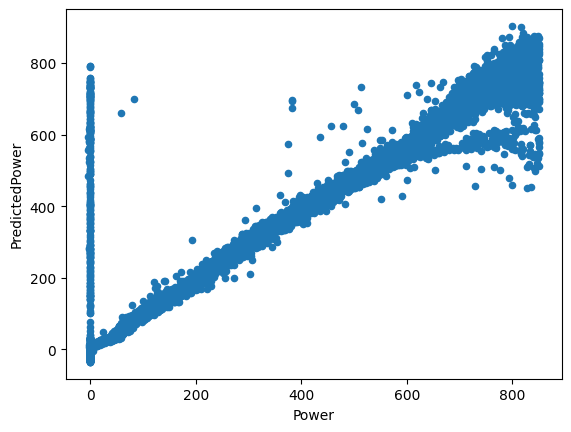

In [14]:
df.plot(x = 'Power', y = 'PredictedPower', kind = 'scatter')

In [16]:
# What do I need to save? 
# The model, the xScaler, the yScaler
torch.save(model.state_dict(),'../models/ffnn.pth')
torch.save(xScaler,'../models/xscaler_ffnn.pth')
torch.save(yScaler,'../models/yscaler_ffnn.pth')

In [24]:
import polars as pl

# dundalk_all = pl.read_excel('../data/dundalk.xlsx').to_pandas()
# dundalk_all = dundalk_all[['Timestamps','WindSpeed','WindDirAbs','EnvirTemp','Power','Pitch']]
print('read')
# Load the model
model = FeedForwardNN(3)
model.load_state_dict(torch.load('../models/ffnn.pth'))

# Load the scalers
xScaler = torch.load('../models/xscaler_ffnn.pth',weights_only=False)
yScaler = torch.load('../models/yscaler_ffnn.pth',weights_only=False)


inp = xScaler.transform(dundalk_all[['WindSpeed','WindDirAbs','EnvirTemp']])
inp = torch.FloatTensor(inp)
pred = model(inp)

dundalk_all['PredictedPower'] = yScaler.inverse_transform(pred.detach().numpy())

(
    dundalk_all.melt(id_vars = 'Timestamps',value_vars=['Power','PredictedPower'])
    .query('Timestamps > "2018-01-01"')
    .query('Timestamps <= "2018-12-31"')
    .plot(x = 'Timestamps', y = 'value', color = 'variable', backend = 'plotly', height = 600)
)

read


<Axes: xlabel='Power', ylabel='PredictedPower'>

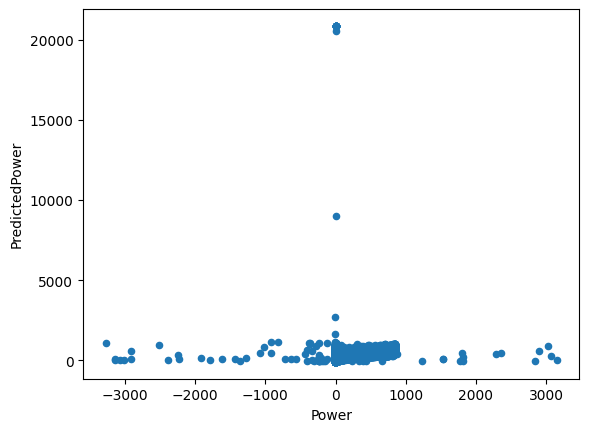

In [ ]:
# dundalk_all.plot(x = 'Power', y = 'PredictedPower', kind = 'scatter')